In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
data_df = pd.read_csv('../input/mnist-digit-recognizer/train.csv')
data_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
labels = data_df.iloc[:,0]
image_data = data_df.iloc[:,1:]
print(labels.shape, image_data.shape)

(42000,) (42000, 784)


In [4]:
class Linear(tf.keras.layers.Layer):
    """
    - Units: number of neuron in that layer
    - First layer uses n nodes, 
    - relu activation
    """
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        #weights should be normal initializer otherwise there will be vanishing gradient problem
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
                    initial_value=w_init(shape=(input_dim, units), dtype='float32')
                    , trainable=True
                    )
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
                    initial_value=b_init(shape=(units), dtype='float32')
                    , trainable=True
                    )
        
    def call(self, inputs):
        return tf.nn.relu(tf.matmul(inputs, self.w) + self.b)

In [5]:
class Linear2_softmax(Linear):
    """
    This is the second layer which will give binary output 
    hence require softmax activation on the last layer
    """
    def call(self, inputs):
        return tf.nn.softmax(tf.matmul(inputs, self.w) + self.b)

In [6]:
# x = np.array([[4, 1, 0],
#               [2, 3, 0]])
# x = tf.convert_to_tensor(x, dtype='float32')
# linear_layer = Linear(9,3)
# y = linear_layer(x)
# print(linear_layer.w, x, tf.matmul(x, linear_layer.w))

In [7]:
# x_np = x.numpy()
# w_np = linear_layer.w.numpy()

# x_np.dot(w_np)

In [8]:
image_tf = tf.convert_to_tensor(image_data, dtype='float32')
image_tf = image_tf/255
labels_tf = tf.convert_to_tensor(labels, dtype='float32')


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [9]:
input_layer = tf.keras.Input(shape=(784,), name="input" )
hidden_layer = Linear(units=10, input_dim=784)(input_layer)
hidden_layer2 = Linear2_softmax(units=10, input_dim=10)(hidden_layer)
model = tf.keras.models.Model(inputs=input_layer, outputs=hidden_layer2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
linear (Linear)              (None, 10)                7850      
_________________________________________________________________
linear2_softmax (Linear2_sof (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


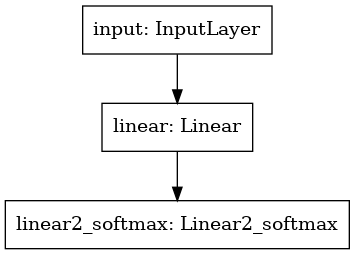

In [10]:
model.summary()
tf.keras.utils.plot_model(model)

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.07)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

for i in range(600):
    with tf.GradientTape() as tape:
        pred = model(image_tf, training=True)
        loss = loss_fn(labels_tf, pred)
    
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    if i%50 == 0:
        print("Step: {}, Loss: {}".format(i, loss))

Step: 0, Loss: 2.306548595428467
Step: 50, Loss: 2.1931989192962646
Step: 100, Loss: 1.7602615356445312
Step: 150, Loss: 1.190902829170227
Step: 200, Loss: 0.8650481104850769
Step: 250, Loss: 0.693806529045105
Step: 300, Loss: 0.5920745730400085
Step: 350, Loss: 0.528484582901001
Step: 400, Loss: 0.4861176908016205
Step: 450, Loss: 0.4561109244823456
Step: 500, Loss: 0.4336983859539032
Step: 550, Loss: 0.41621336340904236


2022-01-29 06:19:57.199644: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


actual: 4.0, pred: 4


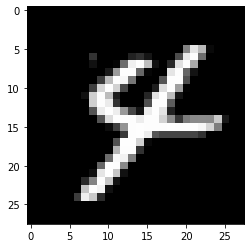

In [12]:
index = np.random.randint(0,image_tf.shape[1])
image = image_tf[index,None]
label = labels_tf[index]
pred = np.argmax(model.predict(image))
print('actual: {}, pred: {}'.format(label, pred))
img = image.numpy().reshape(28, 28) * 255
plt.gray()
plt.imshow(img, interpolation='nearest')
plt.show()